In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 150)


In [44]:
file_path = 'data/labeled_df.csv'
df = pd.read_csv(file_path, index_col=0)

In [45]:
df.set_index('client_id', inplace=True)

In [46]:
df.head()

,avg_frequency,std_frequency,max_frequency,count_sales_day,last_purchase,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,churn
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,
481,14.000000,21.560546,63.0,10,2019-05-23,3415.987600,83.316771,41,28,3,31,11.333333,13.796135,27.0,4.0,2419.634868,219.966806,11.0,11.0,2.0,996.352732,-442.311252,1454.045832,341.598760,604.908717,0.0
485,3.093567,4.324012,45.0,173,2019-06-21,42329.103729,40.818808,1037,355,2,2,3.220588,4.637514,45.0,137.0,34349.075963,39.256087,875.0,319.0,1.0,-2111.759400,-1037.892834,208.338011,244.676900,250.723182,0.0
929,1.000000,0.000000,1.0,5,2019-01-18,1412.293527,36.212655,39,33,1,156,1.000000,0.000000,1.0,4.0,1412.293527,36.212655,39.0,33.0,1.0,NaN,NaN,NaN,282.458705,353.073382,1.0
1118,37.857143,72.470532,286.0,16,2019-06-17,6304.106537,106.849263,59,42,1,6,40.000000,82.032920,286.0,12.0,5582.309497,105.326594,53.0,38.0,1.0,246.322640,515.731453,927.862627,394.006659,465.192458,0.0
1545,148.000000,220.245318,402.0,5,2019-06-17,1662.666189,92.370344,18,10,1,6,10.000000,NaN,10.0,2.0,1194.701880,119.470188,10.0,6.0,1.0,-378.264309,467.964309,467.964309,332.533238,597.350940,1.0


## Drop useless cols

In [47]:
df = df.drop(columns=['last_purchase'])

## EDA

In [48]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

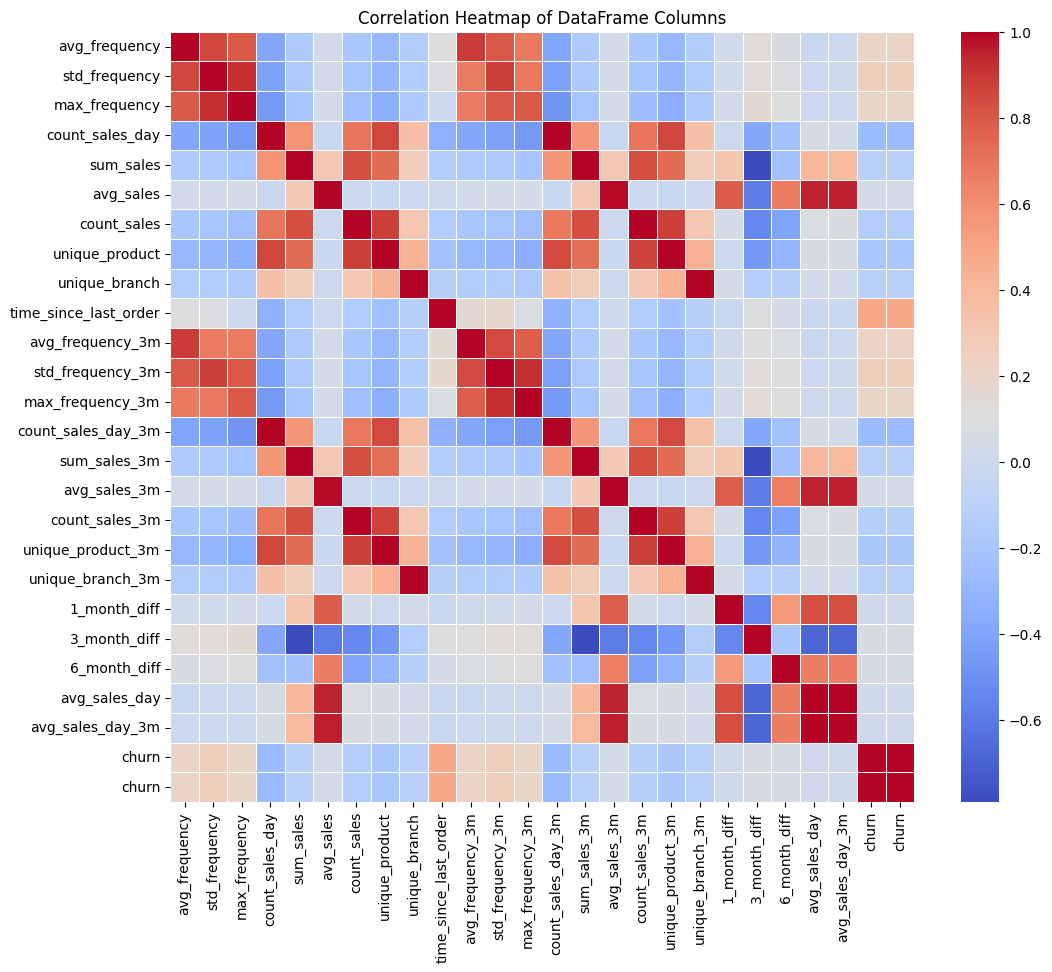

In [49]:
# Compute the correlation matrix
corr = df[numerical_columns + ['churn']].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

## Try models

In [50]:
df = df.fillna(0)

In [27]:
#df = df.drop(columns=['avg_sales_day', 'avg_sales_day_3m'])

In [28]:
df.describe()

,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,1_month_diff,3_month_diff,6_month_diff,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,churn
count,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000
mean,35.900957,32.749700,96.965533,43.450572,5.309449e+04,179.728136,352.931224,155.236409,2.585775,77.115620,478.232074,-4.603123e+03,-4.434805e+03,31.312993,26.114438,79.643898,36.472505,4.477534e+04,177.665276,298.351715,136.354222,2.384929,0.256619
std,45.910835,39.872359,80.564878,67.698138,2.074377e+05,617.840689,1212.717823,336.150460,5.017687,110.632378,12265.078044,2.774845e+04,4.955079e+04,41.673437,32.365999,68.314164,57.063192,1.759051e+05,662.850383,1030.476271,299.374458,4.624428,0.436802
min,0.000000,0.000000,0.000000,0.000000,-7.676301e+01,-1.524018,1.000000,1.000000,1.000000,0.000000,-205444.017798,-1.383604e+06,-1.590752e+06,0.000000,0.000000,0.000000,0.000000,-7.676301e+01,-1.524018,0.000000,0.000000,0.000000,0.000000
25%,7.624094,7.066598,36.000000,5.000000,2.324764e+03,71.209016,22.000000,16.000000,1.000000,5.000000,-211.835589,-2.700710e+03,-4.196156e+03,6.360390,4.837792,28.500000,4.000000,1.790539e+03,67.862043,18.000000,13.000000,1.000000,0.000000
50%,20.136364,19.629909,75.000000,15.000000,8.374202e+03,111.413388,68.000000,47.000000,2.000000,23.000000,146.197200,-1.366931e+02,-3.590797e+02,17.208333,15.452729,62.000000,12.000000,6.885139e+03,108.389442,58.000000,40.000000,2.000000,0.000000
75%,45.000000,43.727311,136.000000,48.000000,3.313615e+04,186.395696,241.000000,147.500000,3.000000,103.000000,796.448462,3.973208e+02,6.298691e+02,39.857143,35.336048,112.000000,40.500000,2.760067e+04,181.429974,204.000000,129.000000,3.000000,1.000000
max,511.000000,366.988419,526.000000,408.000000,8.508021e+06,44988.294824,47832.000000,5127.000000,248.000000,536.000000,813637.927748,1.386434e+05,2.946204e+06,391.000000,280.721392,406.000000,337.000000,7.315048e+06,48194.091788,41715.000000,4604.000000,237.000000,1.000000


In [51]:
# Define features (X) and target variable (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
def train_and_evaluate_model(X, y, model):
    # Define numerical and categorical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create preprocessing pipeline
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create pipeline with preprocessing and the given model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_prob)
    print("AUC Score:", auc_score)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 2))
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return 'done'

Accuracy: 0.8206734534064213
AUC Score: 0.8771218126074928
Recall: 0.4941860465116279
F1 Score: 0.5975395430579965


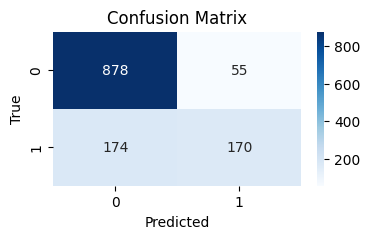

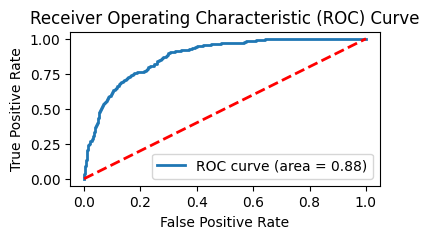

'done'

In [54]:
train_and_evaluate_model(X, y, model=LogisticRegression(random_state=42))

Accuracy: 0.7791699295223179
AUC Score: 0.8766077170418006
Recall: 0.7761627906976745
F1 Score: 0.6544117647058824


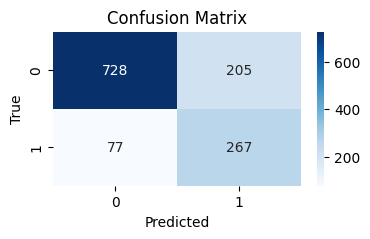

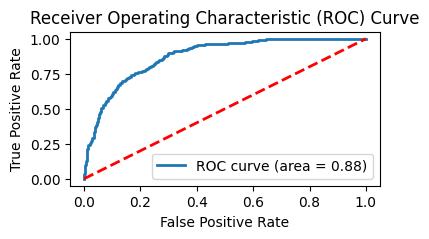

'done'

In [55]:
train_and_evaluate_model(X, y, model=LogisticRegression(class_weight='balanced', random_state=42))

Accuracy: 0.8214565387627252
AUC Score: 0.8845247887534584
Recall: 0.5755813953488372
F1 Score: 0.6346153846153846


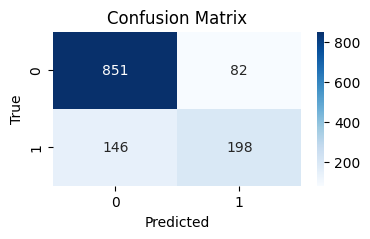

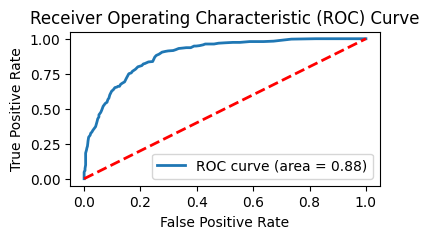

'done'

In [56]:
train_and_evaluate_model(X, y, model=RandomForestClassifier(random_state=42))

Accuracy: 0.8151918559122945
AUC Score: 0.8839156634013808
Recall: 0.5552325581395349
F1 Score: 0.6181229773462783


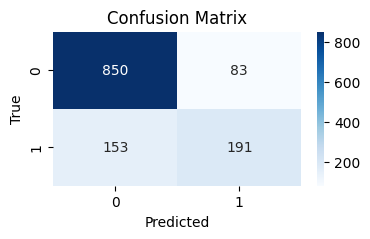

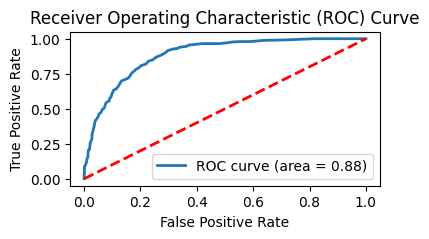

'done'

In [34]:
train_and_evaluate_model(X, y, model=RandomForestClassifier(class_weight='balanced', random_state=42))

Accuracy: 0.8128425998433829
AUC Score: 0.8762867967795807
Recall: 0.6075581395348837
F1 Score: 0.6362252663622526


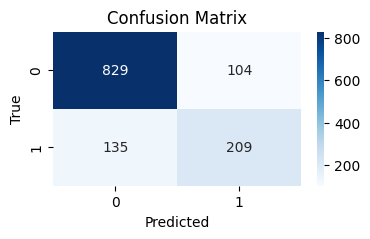

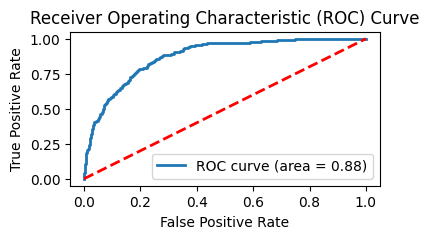

'done'

In [35]:
train_and_evaluate_model(X, y, model=xgb.XGBClassifier(random_state=42))

Accuracy: 0.8128425998433829
AUC Score: 0.8743332336299509
Recall: 0.6831395348837209
F1 Score: 0.6629055007052186


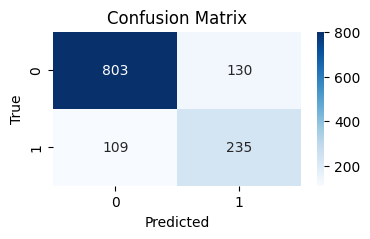

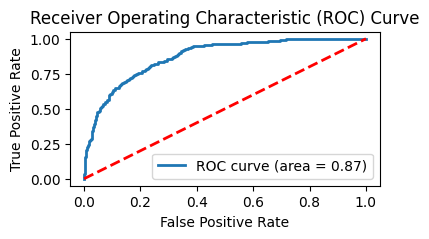

'done'

In [38]:
train_and_evaluate_model(X, y, model=xgb.XGBClassifier(random_state=42, scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)))

## Tune mode

In [39]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
}

xgb_model = xgb.XGBClassifier(scale_pos_weight=sum(y_train == False) / sum(y_train == True))

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}
Best F1 Score: 0.6707636575860406


## Interprete model

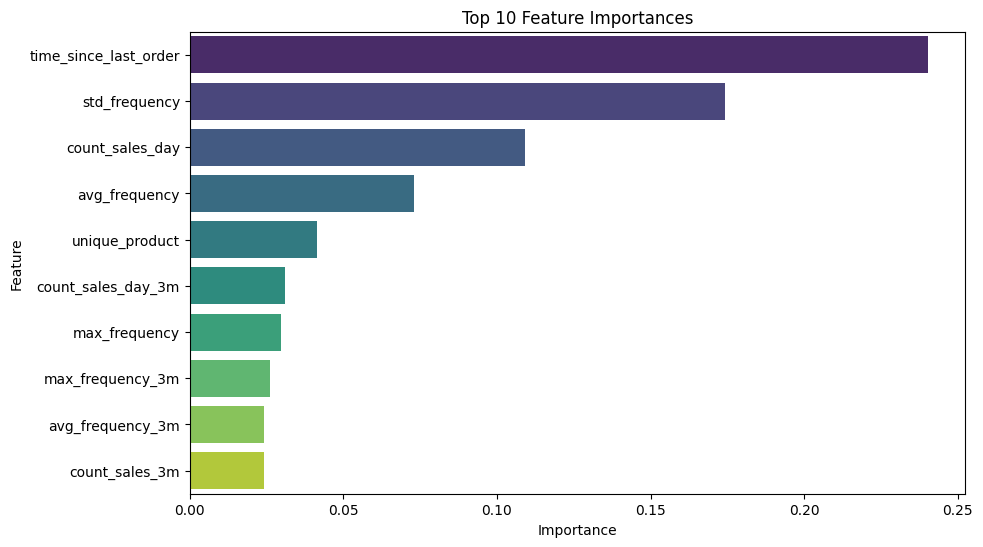

In [42]:
# Get the one-hot encoded feature names from the preprocessor
#onehot_columns = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

# Combine numerical and one-hot encoded feature names
transformed_feature_names = list(numerical_features)

# Get feature importances
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df[:10], palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


 92%|==================  | 4680/5106 [00:11<00:01]       

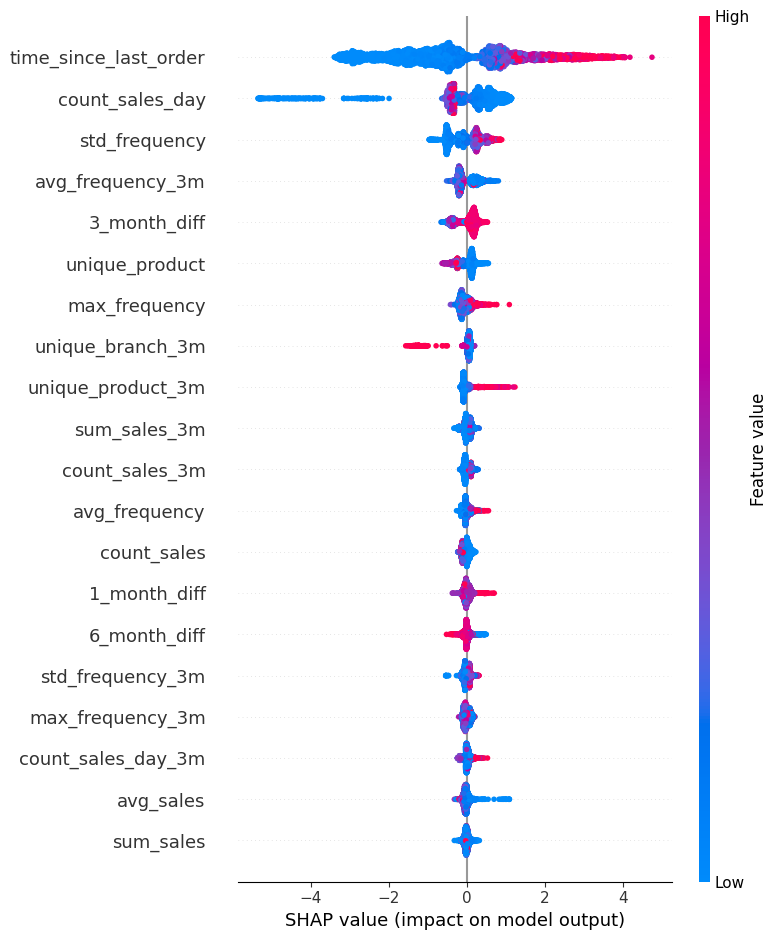

In [43]:
# Get the preprocessed data
X_train_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Initialize the XGBoost model (without scale_pos_weight as it's not supported in SHAP)
xgb_model = grid_search.best_estimator_.named_steps['classifier']

# Create a SHAP explainer object
explainer = shap.Explainer(xgb_model, X_train_transformed)

# Calculate Shapley values
shap_values = explainer.shap_values(X_train_transformed)

# Summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=transformed_feature_names)


## Extract model output

In [57]:
model = xgb.XGBClassifier(scale_pos_weight=sum(y_train == False) / sum(y_train == True), learning_rate= 0.1, max_depth=4, n_estimators=100)

Accuracy: 0.7854346123727486
AUC Score: 0.8940760612178769
Recall: 0.8401162790697675
F1 Score: 0.6784037558685446


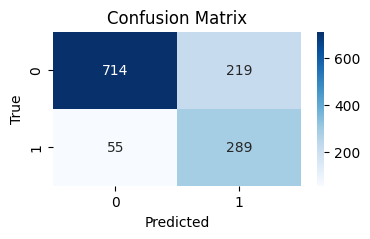

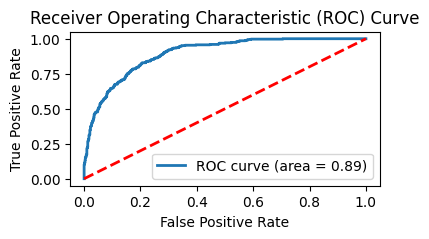

In [58]:

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessing and the given model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4, 2))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [63]:
pred_dataset = X_test.copy()
pred_dataset['y_prob'] = y_prob
pred_dataset['y_pred'] = y_pred

In [65]:
pred_dataset.reset_index(inplace=True)

In [67]:
pred_dataset.sort_values(by='y_prob', inplace=True)

In [70]:
pred_dataset.describe()

,client_id,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,y_prob,y_pred
count,1.277000e+03,1277.000000,1277.000000,1277.000000,1277.000000,1.277000e+03,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1.277000e+03,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000
mean,1.113589e+06,36.497740,33.192419,99.516836,45.035239,5.124166e+04,181.427145,336.454190,148.889585,2.494910,78.324980,30.930876,26.746551,81.147220,37.247455,4.316927e+04,178.182678,284.285043,130.883320,2.293657,174.949138,-4117.446643,-4321.330122,794.273679,841.271075,0.378813,0.397807
std,6.657780e+05,49.318498,40.465680,83.454561,67.480889,1.837463e+05,333.605746,984.456202,317.050844,2.577212,111.910112,40.660205,32.524922,69.622562,57.035323,1.549812e+05,340.534561,823.227866,279.765516,2.243919,6565.304064,22203.131587,26275.575802,1792.430009,2008.197331,0.339311,0.489637
min,3.257000e+03,0.000000,0.000000,0.000000,2.000000,-4.572055e+01,-1.524018,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.572055e+01,-1.524018,0.000000,0.000000,0.000000,-71465.032403,-496174.820623,-563350.692784,-7.620092,-9.144110,0.001173,0.000000
25%,5.327660e+05,7.746269,7.402320,39.000000,7.000000,2.278546e+03,72.334907,21.000000,16.000000,1.000000,5.000000,6.457627,5.066867,29.000000,5.000000,1.789459e+03,69.139465,16.000000,13.000000,1.000000,-257.996520,-2440.882949,-4409.012887,241.393168,250.727982,0.027723,0.000000
50%,1.121474e+06,20.500000,19.514286,77.000000,16.000000,8.368230e+03,111.130012,65.000000,45.000000,2.000000,24.000000,17.428571,15.372408,63.000000,13.000000,6.730481e+03,107.628518,56.000000,40.000000,2.000000,127.513840,-128.251036,-385.934749,450.491006,475.979560,0.314536,0.000000
75%,1.697728e+06,45.500000,42.551353,140.000000,49.000000,3.357051e+04,187.468008,248.000000,149.000000,3.000000,102.000000,41.000000,37.305886,113.000000,41.000000,2.803322e+04,183.073368,209.000000,128.000000,3.000000,727.464921,445.763285,618.353344,835.150860,886.670986,0.693518,1.000000
max,2.273424e+06,511.000000,366.988419,526.000000,410.000000,4.610239e+06,5562.145200,16143.000000,4879.000000,32.000000,513.000000,362.000000,261.629509,406.000000,338.000000,3.906900e+06,5562.145200,13264.000000,4264.000000,23.000000,68919.143193,138643.357453,241268.042070,36000.417211,40658.541450,0.984380,1.000000


In [ ]:
# 10 client > 0.9

# 10 clients < 0.2

# 10 client entre 0.6 et 0.8

In [76]:

# Filter the dataset based on the conditions
selected_data = pred_dataset[(pred_dataset['y_prob'] > 0.9) & (pred_dataset['client_id'].isin(pred_dataset.nlargest(5, 'y_prob')['client_id'])) |
                             (pred_dataset['y_prob'] < 0.2) & (pred_dataset['client_id'].isin(pred_dataset.nsmallest(5, 'y_prob')['client_id'])) |
                             ((pred_dataset['y_prob'] >= 0.6) & (pred_dataset['y_prob'] <= 0.8)) & (pred_dataset['client_id'].isin(pred_dataset[(pred_dataset['y_prob'] >= 0.7) & (pred_dataset['y_prob'] <= 0.8)]['client_id'].head(10)))]


In [77]:
selected_data

,client_id,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,y_prob,y_pred
583,2185689,1.924188,1.423671,9.0,279,392287.405141,126.912781,3091,1647,7,2,1.973094,1.448576,9.0,224.0,309508.016267,132.494870,2336.0,1340.0,7.0,5362.508481,-59990.475030,-7431.951187,1406.048047,1381.732215,0.001173,0
318,521951,4.100000,3.879683,22.0,132,28692.901716,61.178895,469,303,8,2,4.121495,3.956629,22.0,108.0,20970.922847,55.332250,379.0,252.0,8.0,1418.339129,-4998.142276,1327.578804,217.370468,194.175212,0.001196,0
444,553352,4.196850,5.498974,45.0,129,268355.042901,114.242249,2349,538,10,2,4.752688,6.232202,45.0,94.0,186279.225887,125.949443,1479.0,378.0,8.0,-8274.615344,-69542.248993,43980.782803,2080.271650,1981.693892,0.001200,0
387,664915,3.503268,2.643573,13.0,155,93588.854753,80.680047,1160,550,9,2,3.523810,2.738508,13.0,127.0,77880.164885,81.464608,956.0,472.0,9.0,-786.932319,-3748.961898,-19861.405879,603.799063,613.229645,0.001233,0
1257,810079,2.481481,2.302603,21.0,218,127788.267220,100.699974,1269,754,8,2,2.405405,1.914752,12.0,186.0,110428.220530,100.939873,1094.0,676.0,8.0,7071.903488,-4473.868770,-12764.677441,586.184712,593.700110,0.001327,0
850,1173400,9.122449,7.983401,30.0,51,21216.045607,117.866920,180,132,1,74,8.956522,8.074532,30.0,47.0,19196.082874,114.946604,167.0,124.0,1.0,1423.136398,1633.074148,-590.301316,416.000894,408.427295,0.700532,1
1266,1097739,118.250000,137.371455,308.0,6,645.341462,92.191637,7,7,1,65,115.000000,168.056538,308.0,4.0,637.111142,106.185190,6.0,6.0,1.0,8.230320,-47.251200,-47.251200,107.556910,159.277786,0.701168,1
232,1754985,55.333333,38.619511,110.0,8,2255.763640,132.691979,17,13,1,178,55.333333,38.619511,110.0,7.0,2255.763640,132.691979,17.0,13.0,1.0,331.429080,320.747880,-179.785480,281.970455,322.251949,0.708029,1
951,2175784,63.857143,87.037212,248.0,9,4408.554287,122.459841,36,28,1,75,83.000000,98.782590,248.0,6.0,3339.195353,104.349855,32.0,26.0,1.0,-2169.114667,2210.674133,2210.674133,489.839365,556.532559,0.709201,1
366,1843544,3.625000,3.637079,27.0,130,171714.951935,206.140398,833,420,4,73,3.480000,3.453843,27.0,126.0,170140.259286,205.483405,828.0,418.0,4.0,-3502.743544,-11975.077941,-125986.549545,1320.884246,1350.319518,0.711629,1


In [80]:
selected_data.to_csv('tableau_churn_pred.csv')

In [78]:
tableau_clients_list = list(selected_data['client_id'])

In [79]:
tableau_clients_list

[2185689,
 521951,
 553352,
 664915,
 810079,
 1173400,
 1097739,
 1754985,
 2175784,
 1843544,
 1602677,
 2205826,
 444115,
 691064,
 1307717,
 358717,
 1564688,
 1199790,
 571921,
 366373]